## AISE4010- Project - Time Series Forecasting On Air Quality in Bejing

Dataset sample:
                     No  year  month  day  hour  season  PM_Dongsi  \
datetime                                                             
2010-01-01 00:00:00   1  2010      1    1     0       4        NaN   
2010-01-01 01:00:00   2  2010      1    1     1       4        NaN   
2010-01-01 02:00:00   3  2010      1    1     2       4        NaN   
2010-01-01 03:00:00   4  2010      1    1     3       4        NaN   
2010-01-01 04:00:00   5  2010      1    1     4       4        NaN   

                     PM_Dongsihuan  PM_Nongzhanguan  PM_US Post  DEWP  HUMI  \
datetime                                                                      
2010-01-01 00:00:00            NaN              NaN         NaN -21.0  43.0   
2010-01-01 01:00:00            NaN              NaN         NaN -21.0  47.0   
2010-01-01 02:00:00            NaN              NaN         NaN -21.0  43.0   
2010-01-01 03:00:00            NaN              NaN         NaN -21.0  55.0   
2010-01-01 04:00:00

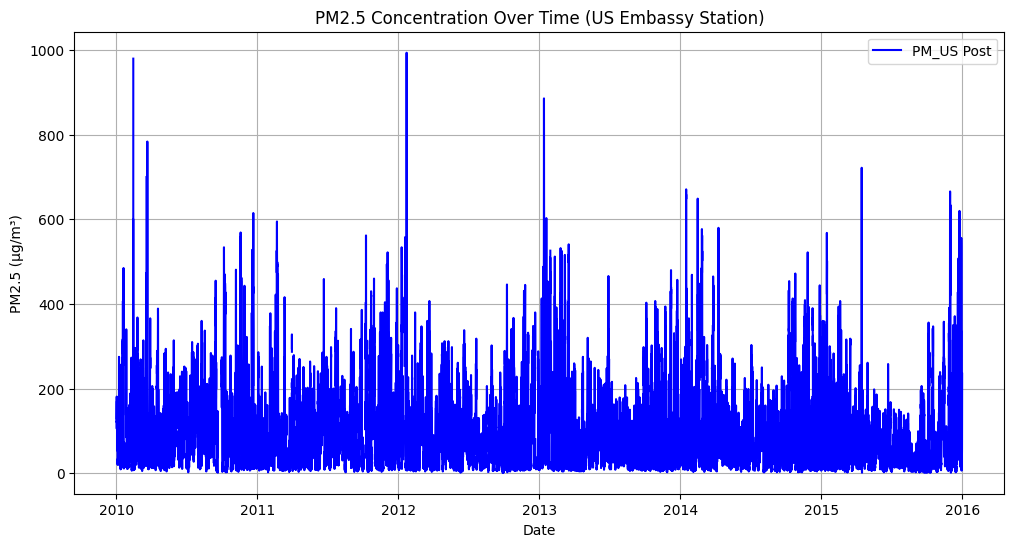

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Beijing.csv')

# Combine date components into a single datetime column
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set datetime as the index and sort
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

print('Dataset sample:')
print(df.head())
plt.figure(figsize=(12,6))
plt.plot(df.index, df['PM_US Post'], label='PM_US Post', color='blue')
plt.title('PM2.5 Concentration Over Time (US Embassy Station)')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
# Combine date columns into datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

# Handle missing values
numeric_cols = ['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post',
                'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation', 'Iprec']

# Interpolate numeric columns by time
df[numeric_cols] = df[numeric_cols].interpolate(method='time')

# Forward fill categorical column
df['cbwd'].fillna(method='ffill', inplace=True)

# Drop any remaining NaNs
df.dropna(inplace=True)

print("Missing values handled. Remaining NaNs per column:")
print(df.isna().sum())

Missing values handled. Remaining NaNs per column:
No                 0
year               0
month              0
day                0
hour               0
season             0
PM_Dongsi          0
PM_Dongsihuan      0
PM_Nongzhanguan    0
PM_US Post         0
DEWP               0
HUMI               0
PRES               0
TEMP               0
cbwd               0
Iws                0
precipitation      0
Iprec              0
dtype: int64


C:\Users\sixel\AppData\Local\Temp\ipykernel_3220\939051922.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cbwd'].fillna(method='ffill', inplace=True)
C:\Users\sixel\AppData\Local\Temp\ipykernel_3220\939051922.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['cbwd'].fillna(method='ffill', inplace=True)


In [ ]:
# Remove duplicate timestamps in case
before = len(df)
df = df[~df.index.duplicated(keep='first')]
after = len(df)
print(f"Removed {before - after} duplicate rows. Remaining rows: {after}")

Removed 0 duplicate rows. Remaining rows: 24760


In [23]:
# One-hot encode wind direction (cbwd)
df = pd.get_dummies(df, columns=['cbwd'], prefix='cbwd')
print("Categorical variable 'cbwd' encoded.")
print("New columns:", [col for col in df.columns if 'cbwd_' in col])


Categorical variable 'cbwd' encoded.
New columns: ['cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']


In [25]:
import numpy as np

target = 'PM_US Post'
features = ['year', 'month', 'day', 'hour', 'season',
            'DEWP', 'TEMP', 'HUMI', 'PRES',
            'Iws', 'precipitation', 'Iprec', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']

# Convert to arrays #
# Ensure all columns are numeric
data = df[features + [target]].astype(np.float32).values
window_size = 10

# Sliding window
def sliding_window(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window, :-1])  #all features except target
        y.append(data[i+window, -1])     #only the target column
    return np.array(X), np.array(y)

X, y = sliding_window(data, window_size)

# Split into 80% training and 20% testing 
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"# of sequences in training samples: {len(X_train)}")
print(f"# of sequences in testing samples: {len(X_test)}")
print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)  
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


# of sequences in training samples: 19800
# of sequences in testing samples: 4950
X_train shape: (19800, 10, 16)
y_train shape: (19800,)
X_test shape: (4950, 10, 16)
y_test shape: (4950,)


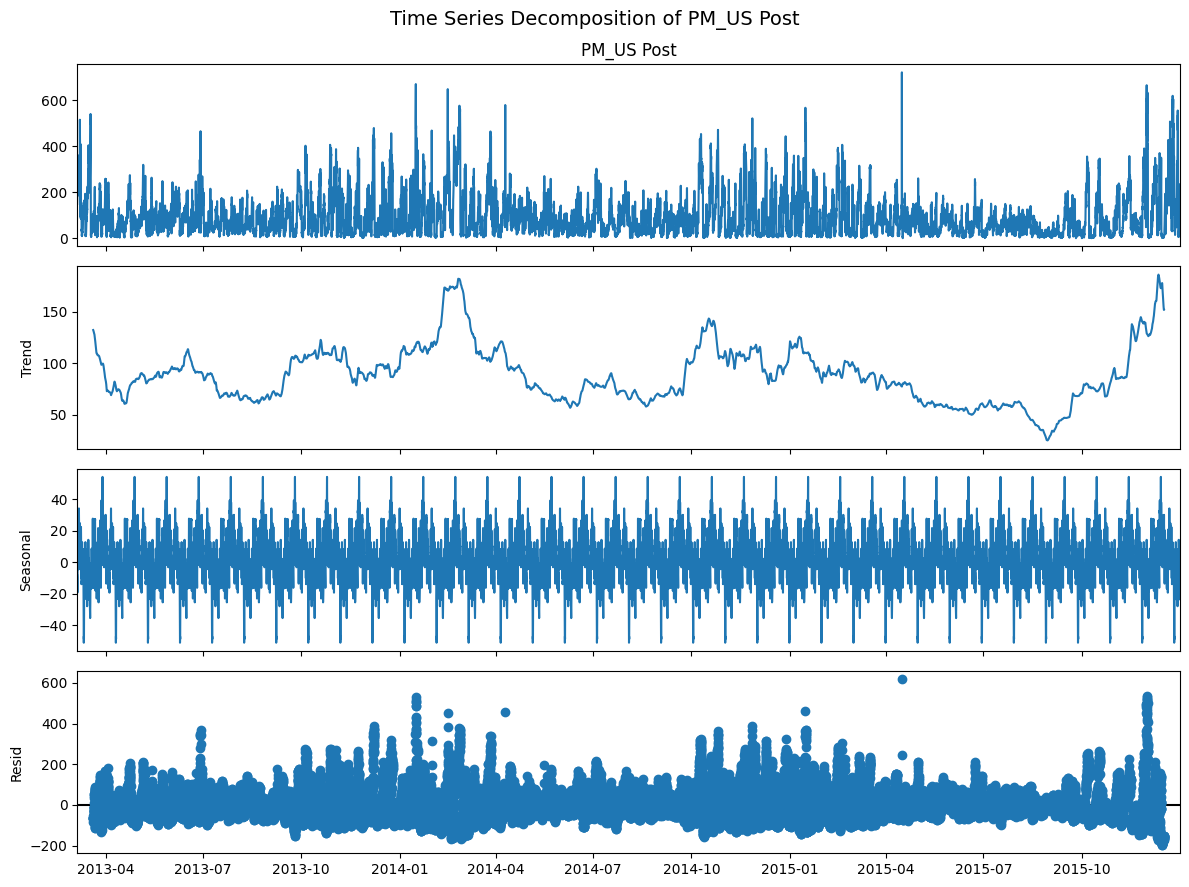

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

target_col = 'PM_US Post'

# Perform additive decomposition
# Period is monthly !!!! i think 
decomposition = seasonal_decompose(df[target_col], model='additive', period=720)

plt.rcParams.update({'figure.figsize': (12, 9)})
decomposition.plot()
plt.suptitle(f'Time Series Decomposition of {target_col}', fontsize=14)
plt.tight_layout()
plt.show()


### CNN

Epoch 1/25


c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


495/495 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0526 - val_loss: 0.0088
Epoch 2/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 3/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 4/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0069 - val_loss: 0.0092
Epoch 5/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 6/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0060 - val_loss: 0.0101
Epoch 7/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0053 - val_loss: 0.0087
Epoch 8/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0050 - val_loss: 0.0085
Epoch 9/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0047 - val_loss: 0.0080
Epoch 10/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0045 - val_loss: 0.0080
Epoch 11/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0041 - val_loss: 0.0092
Epoch 12/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss

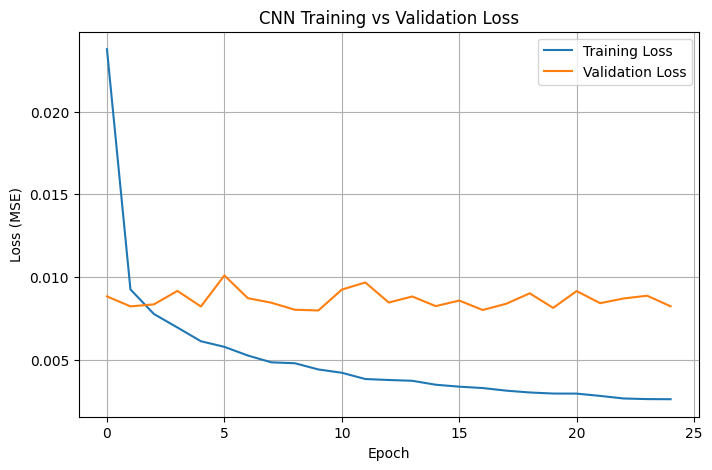

In [27]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Extract shape info for reshaping
n_samples, window, n_features = X_train.shape

# Flatten the time dimension = convert 3D to 2D for scaler to process
X_train_flat = X_train.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

# Create/fit the scaler
scaler_X = StandardScaler()
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_test_scaled_flat = scaler_X.transform(X_test_flat)

# Reshape back to 3D for CNN
X_train_scaled = X_train_scaled_flat.reshape(n_samples, window, n_features)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape[0], window, n_features)

# Scale target variable
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Build 1D CNN
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, n_features)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1)  # regression output
])

model.compile(optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), loss='mse')

# Train
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("CNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 44226.61063206178
MAE: 1277.170654296875
R²: -211707.484375


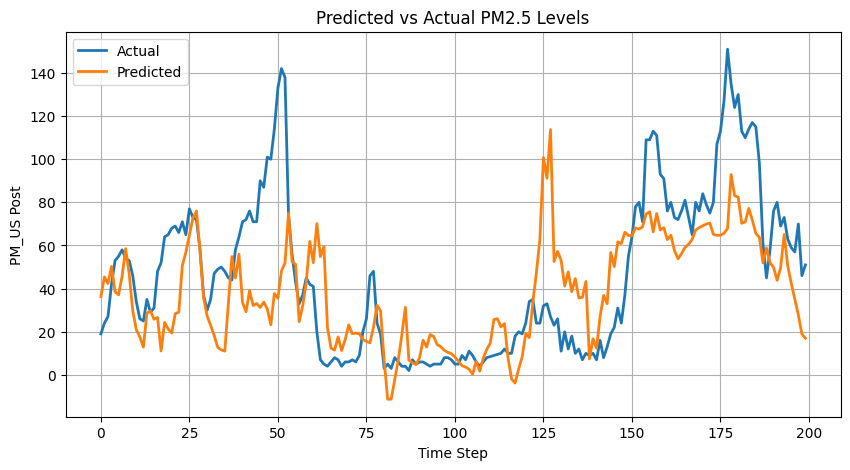

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Predict
y_pred_scaled = model.predict(X_test_scaled)

# Convert back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R²:", r2_score(y_true, y_pred))
plt.figure(figsize=(10,5))
plt.plot(y_true[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linewidth=2)
plt.title("Predicted vs Actual PM2.5 Levels")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


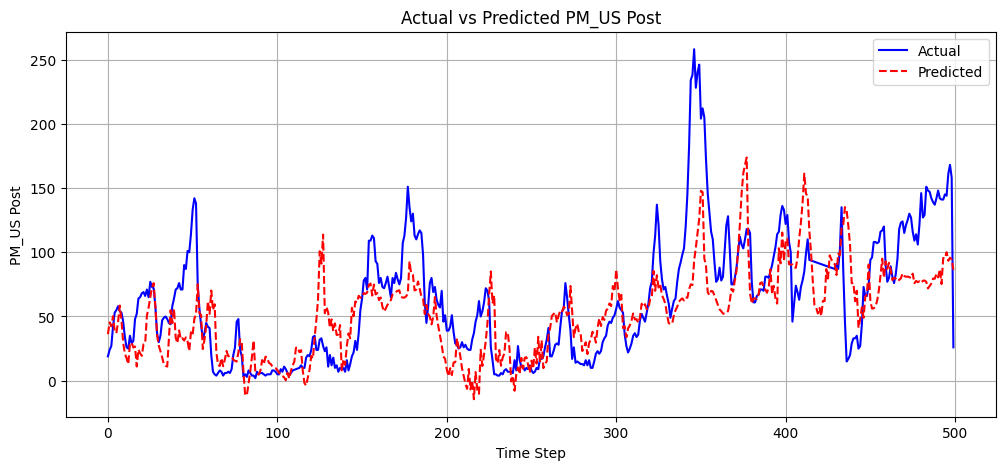

In [31]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

plt.figure(figsize=(12,5))
plt.plot(y_test[:500], label='Actual', color='blue')
plt.plot(y_pred[:500], label='Predicted', color='red', linestyle='--')
plt.title("Actual vs Predicted PM_US Post")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()

### LSTM


c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.0193 - val_loss: 0.0091
Epoch 2/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0095 - val_loss: 0.0162
Epoch 3/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0085 - val_loss: 0.0095
Epoch 4/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0076 - val_loss: 0.0137
Epoch 5/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0069 - val_loss: 0.0147
Epoch 6/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0068 - val_loss: 0.0146
Epoch 7/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0062 - val_loss: 0.0102
Epoch 8/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0058 - val_loss: 0.0095
Epoch 9/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0053 - val_loss: 0.0100
Epoch 10/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0050 - val_loss: 0.0142
Epoch 11/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0049 - val_loss: 0.0099
Epoch 12/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 

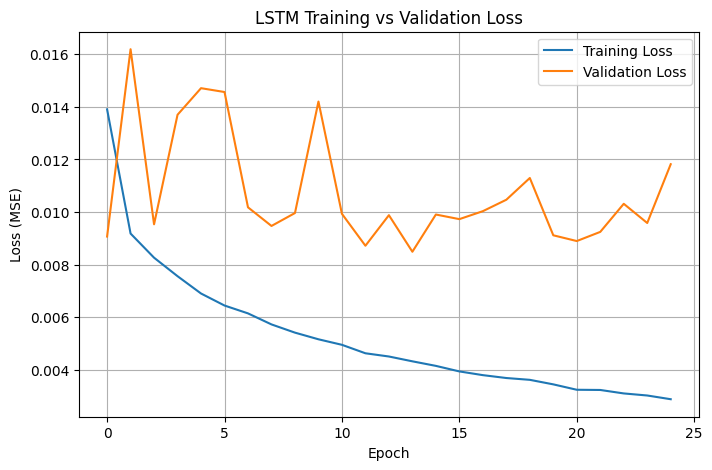

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM

model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(window_size, n_features)),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dropout(0.3),
    Dense(1)  # regression output
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Train
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE: 82.56032358978494
MAE: 52.72591018676758
R²: 0.2622423768043518


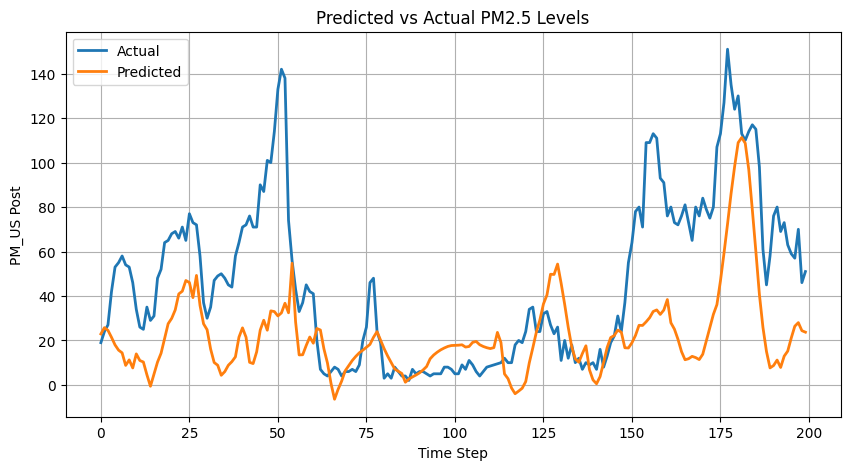

In [34]:
y_pred_scaled = model.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R²:", r2_score(y_true, y_pred))

plt.figure(figsize=(10,5))
plt.plot(y_true[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linewidth=2)
plt.title("Predicted vs Actual PM2.5 Levels")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


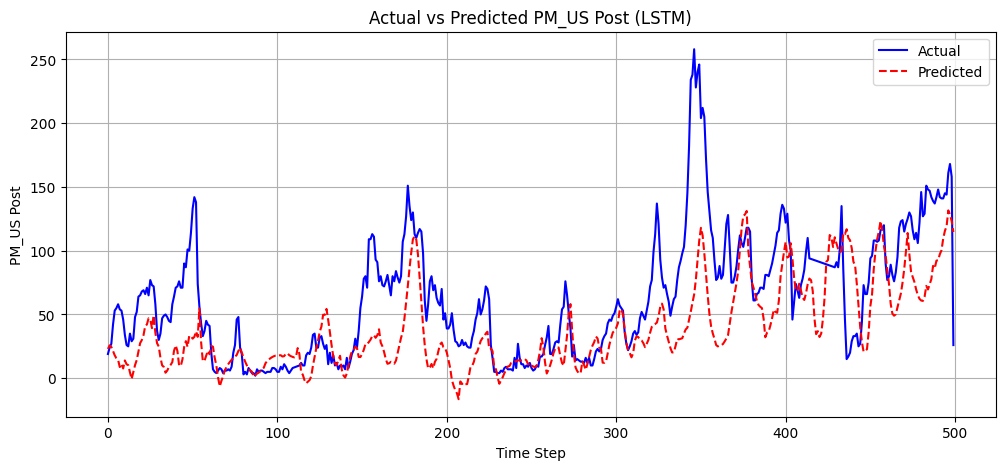

In [35]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

plt.figure(figsize=(12,5))
plt.plot(y_test[:500], label='Actual', color='blue')
plt.plot(y_pred[:500], label='Predicted', color='red', linestyle='--')
plt.title("Actual vs Predicted PM_US Post (LSTM)")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()

### RNN

Epoch 1/25


c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.6745 - val_loss: 0.0221
Epoch 2/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1684 - val_loss: 0.0112
Epoch 3/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0638 - val_loss: 0.0104
Epoch 4/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0304 - val_loss: 0.0087
Epoch 5/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0172 - val_loss: 0.0083
Epoch 6/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0120 - val_loss: 0.0082
Epoch 7/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 8/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0097 - val_loss: 0.0083
Epoch 9/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 10/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 11/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0092 - val_loss: 0.0082
Epoch 12/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

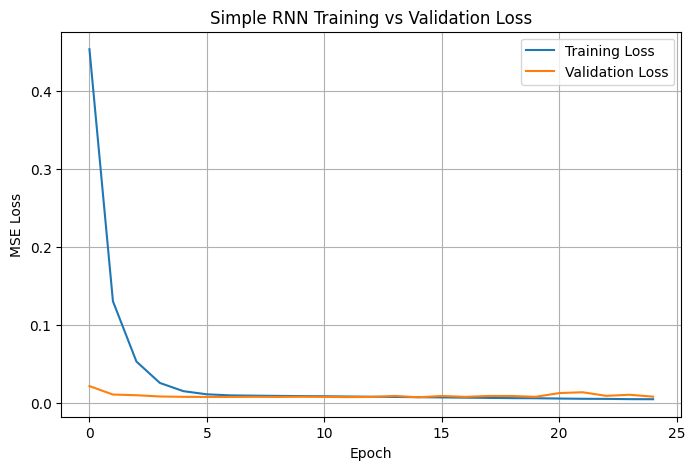

In [36]:
from tensorflow.keras.layers import SimpleRNN

model = Sequential([
    SimpleRNN(64, activation='tanh', return_sequences=True, input_shape=(window_size, n_features)),
    Dropout(0.3),
    SimpleRNN(32, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Simple RNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 104.42903728429656
MAE: 78.6802749633789
R²: -0.18035733699798584


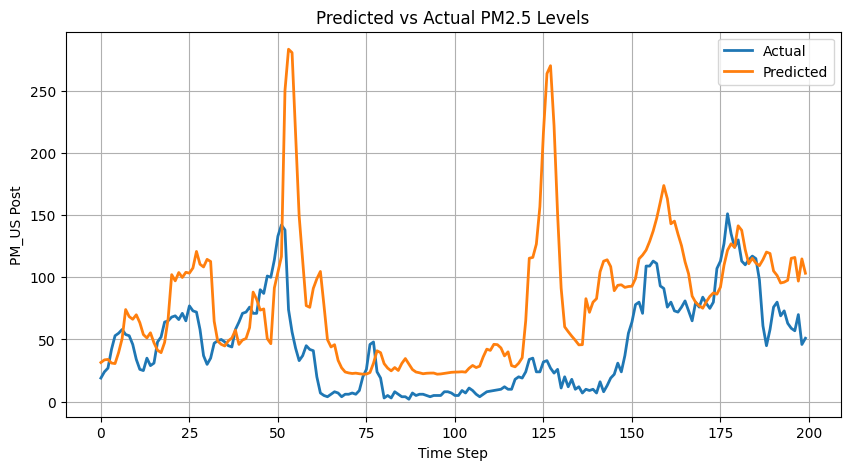

In [39]:
y_pred_scaled = model.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R²:", r2_score(y_true, y_pred))

plt.figure(figsize=(10,5))
plt.plot(y_true[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linewidth=2)
plt.title("Predicted vs Actual PM2.5 Levels")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


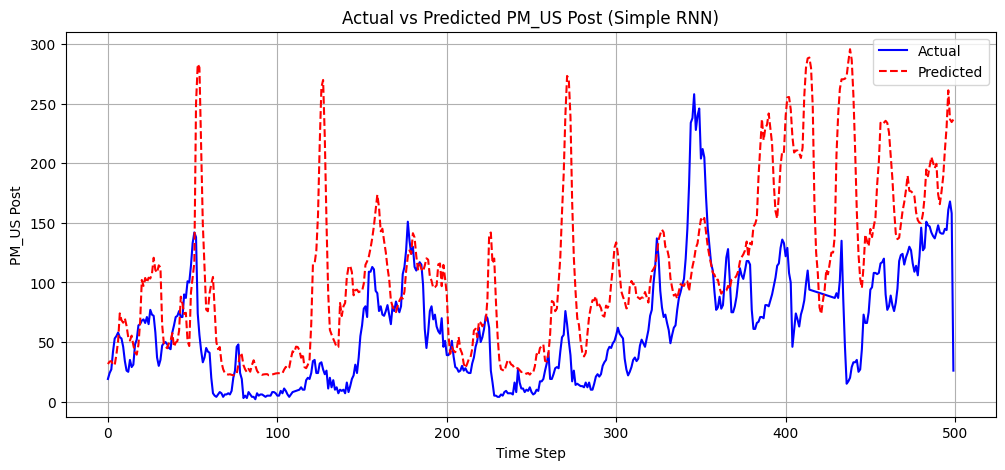

In [40]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

plt.figure(figsize=(12,5))
plt.plot(y_test[:500], label='Actual', color='blue')
plt.plot(y_pred[:500], label='Predicted', color='red', linestyle='--')
plt.title("Actual vs Predicted PM_US Post (Simple RNN)")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()

### GRU

Epoch 1/25


c:\Users\sixel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


495/495 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0602 - val_loss: 0.0086
Epoch 2/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0160 - val_loss: 0.0076
Epoch 3/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 4/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0110 - val_loss: 0.0090
Epoch 5/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 6/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 7/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 8/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 9/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0078 - val_loss: 0.0106
Epoch 10/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0071 - val_loss: 0.0078
Epoch 11/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0071 - val_loss: 0.0086
Epoch 12/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss

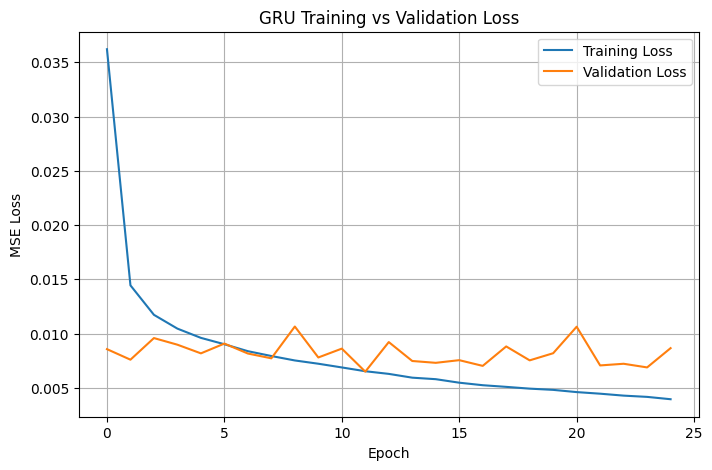

In [41]:
from tensorflow.keras.layers import GRU

model = Sequential([
    GRU(64, activation='tanh', return_sequences=True, input_shape=(window_size, n_features)),
    Dropout(0.3),
    GRU(32, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("GRU Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 79.75884061500643
MAE: 51.55511474609375
R²: 0.31146085262298584


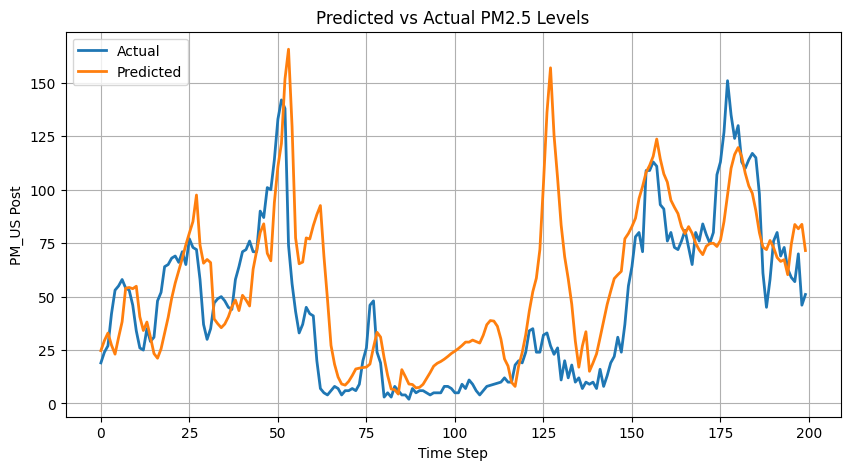

In [42]:
y_pred_scaled = model.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R²:", r2_score(y_true, y_pred))

plt.figure(figsize=(10,5))
plt.plot(y_true[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linewidth=2)
plt.title("Predicted vs Actual PM2.5 Levels")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


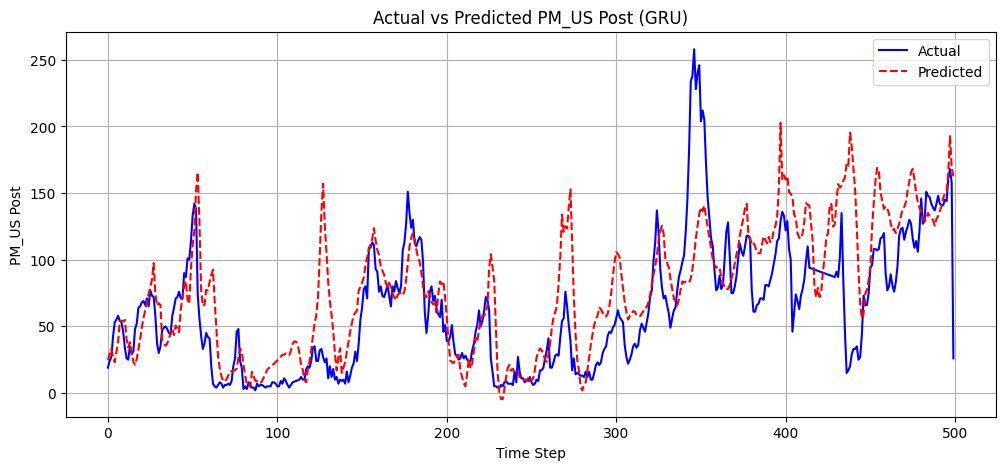

In [43]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

plt.figure(figsize=(12,5))
plt.plot(y_test[:500], label='Actual', color='blue')
plt.plot(y_pred[:500], label='Predicted', color='red', linestyle='--')
plt.title("Actual vs Predicted PM_US Post (GRU)")
plt.xlabel("Time Step")
plt.ylabel("PM_US Post")
plt.legend()
plt.grid(True)
plt.show()